## **EDA Notebook**

**IMPORTANT:** run `setup_data.py`

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append('../')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from src.utils.visualizations import *
from src.utils.preproc import *
from setup_data import update_image_paths

In [2]:
# because the utils in the src are designed to be run from the root of the project,
# and by default jupyter runs from the notebook directory we need to change the working directory to the root

def find_project_root(filename=".git"): # .git is located in the root of the project
    current_dir = os.getcwd()
    while current_dir != os.path.dirname(current_dir): # stops only when at the root (moves up 1 level each iteration)
        if filename in os.listdir(current_dir):
            return current_dir
        current_dir = os.path.dirname(current_dir)

project_root = find_project_root()
os.chdir(project_root)  # change the working directory to the project root

print("Project root:", project_root, "CWD:", os.getcwd())

Project root: d:\deep_learning_project CWD: d:\deep_learning_project


In [ ]:
train_gen, val_gen, test_gen, class_weights = preproc_pipeline(desired_magnification='200X', 
                                                    image_resolution=(224, 224), 
                                                    classification_type='multiclass',
                                                    use_data_augmentation=True,
                                                    augmented_images_per_image=6)

In [5]:
img_metadata_df = pd.read_csv('image_metadata/image_data.csv')
img_metadata_df.isnull().sum()

path_to_image          0
Benign or Malignant    3
Cancer Type            4
Magnification          4
dtype: int64

In [6]:
img_metadata_df.dropna(inplace=True)
img_metadata_df.head(3)

path_to_image Benign or Malignant  \
0  BreaKHis_v1/histology_slides/breast/benign/SOB...              Benign   
1  BreaKHis_v1/histology_slides/breast/benign/SOB...              Benign   
2  BreaKHis_v1/histology_slides/breast/benign/SOB...              Benign   

  Cancer Type Magnification  
0    Adenosis          100X  
1    Adenosis          100X  
2    Adenosis          100X

In [7]:
img_metadata_df.isnull().sum()

path_to_image          0
Benign or Malignant    0
Cancer Type            0
Magnification          0
dtype: int64

In [11]:
def get_image_location(row):
    # because the path contains the split, we can use it to create a new column for further analysis
    possible_locations = ['train', 'test', 'val']
    for location in possible_locations:
        if location in row['path_to_image']:
            return location
    return "NOT FOUND"

img_metadata_df = update_image_paths(img_metadata_df)

img_metadata_df['image_location'] = img_metadata_df.apply(get_image_location, axis=1)
img_metadata_df.head(3)

path_to_image Benign or Malignant  \
0  data\100X\train\SOB_B_A-14-22549AB-100-011.png              Benign   
1   data\100X\test\SOB_B_A-14-22549AB-100-005.png              Benign   
2   data\100X\test\SOB_B_A-14-22549AB-100-004.png              Benign   

  Cancer Type Magnification image_location  
0    Adenosis          100X          train  
1    Adenosis          100X           test  
2    Adenosis          100X           test

<i> The updated version of the image metadata csv files contains the actual image paths, and the missing images have been removed. </i>

In [12]:
# pivot table to check the distribution of images by magnification and cancer type

grouped = img_metadata_df.groupby(
    ['Benign or Malignant', 'Cancer Type', 'Magnification']
).size().reset_index(name='Count')

pivot_table = grouped.pivot_table(
    index=['Benign or Malignant', 'Cancer Type'],
    columns='Magnification',
    values='Count',
    aggfunc='sum',
    fill_value=0
)

magnification_order = ['40X', '100X', '200X', '400X']
pivot_table = pivot_table.reindex(columns=magnification_order, fill_value=0)

pivot_table['Total'] = pivot_table.sum(axis=1)

pivot_table = pivot_table.astype(int) # remove decimal points
pivot_table

Magnification                            40X  100X  200X  400X  Total
Benign or Malignant Cancer Type                                      
Benign              Adenosis             114   113   111   106    444
                    Fibroadenoma         253   260   264   237   1014
                    Phyllodes Tumor      109   121   108   115    453
                    Tubular Adenoma      149   150   140   130    569
Malignant           Ductal Carcinoma     863   903   896   788   3450
                    Lobular Carcinoma    156   170   163   137    626
                    Mucinous Carcinoma   205   221   195   168    789
                    Papillary Carcinoma  145   142   135   138    560

<i>Notes :<br> 
- The binary classification <b>(Benign or Malignant) is unbalanced.</b><br>
- The <b>cancer types</b> within each binary class are <b>also unbalanced</b> (especially D.U (Malignant)).<br>
- Their <b>distributions</b> are <b>similar</b> in <b>all magnifications</b> though.</i>

In [13]:
# pivot table to check the distribution of images by magnification and Benign or Malignant

distribution_table = img_metadata_df.pivot_table(
    index='Magnification',
    columns='Benign or Malignant',
    values='path_to_image',
    aggfunc='count',
    fill_value=0
)

distribution_table['Total'] = distribution_table.sum(axis=1)
distribution_table.loc['Total'] = distribution_table.sum(axis=0)

distribution_table

Benign or Malignant  Benign  Malignant  Total
Magnification                                
100X                    644       1436   2080
200X                    623       1389   2012
400X                    588       1231   1819
40X                     625       1369   1994
Total                  2480       5425   7905

<i> Notes:<br> 
- Like the previous case, the <b>distributions</b> are <b>similar in all magnifications.</b></i>

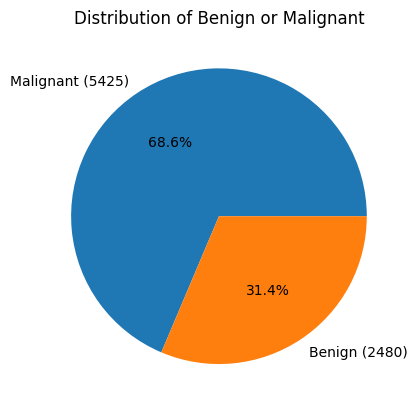

In [14]:
plot_distribution_pie(img_metadata_df, 'Benign or Malignant')

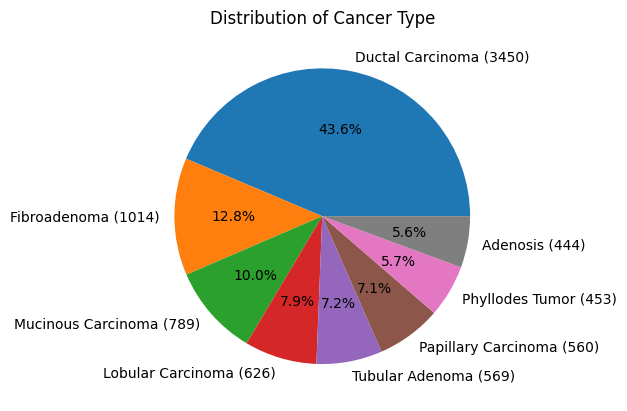

In [15]:
plot_distribution_pie(img_metadata_df, 'Cancer Type')

**Confirmation of the same distribution across splits (stratification was used)**

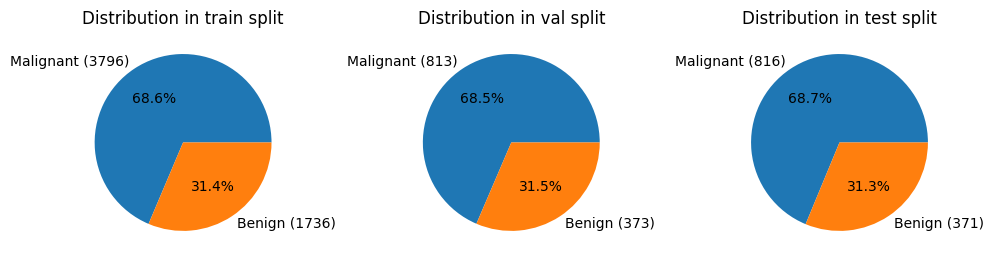

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(10, 6))

splits = ['train', 'val', 'test']
for ax, split in zip(axes, splits):
    plot_distribution_pie(img_metadata_df[img_metadata_df['image_location'] == split], 'Benign or Malignant', ax=ax)
    ax.set_title(f'Distribution in {split} split')

plt.tight_layout()
plt.show()

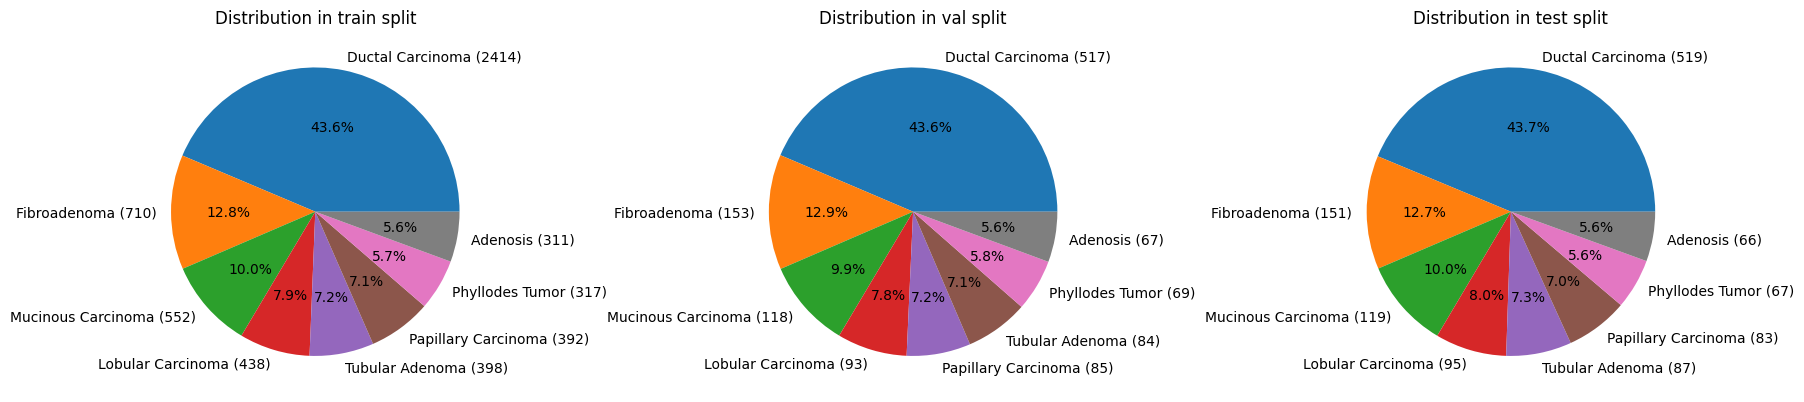

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

splits = ['train', 'val', 'test']
for ax, split in zip(axes, splits):
    plot_distribution_pie(img_metadata_df[img_metadata_df['image_location'] == split], 'Cancer Type', ax=ax)
    ax.set_title(f'Distribution in {split} split')

plt.tight_layout()
plt.show()

**Check for range of image resolutions**

In [18]:
resolutions = check_image_resolutions(img_metadata_df)
resolutions_df = pd.DataFrame(resolutions, columns=['width', 'height'])
print("\nImage Resolutions:\n", resolutions_df.describe())


Image Resolutions:
         width       height
count  7905.0  7905.000000
mean    700.0   459.962555
std       0.0     0.385221
min     700.0   456.000000
25%     700.0   460.000000
50%     700.0   460.000000
75%     700.0   460.000000
max     700.0   460.000000


<i>As there aren't any extremes (max 4 pixels difference in height), no further investigation is needed.</i>

**Visualization of Cancer Types by different magnification**

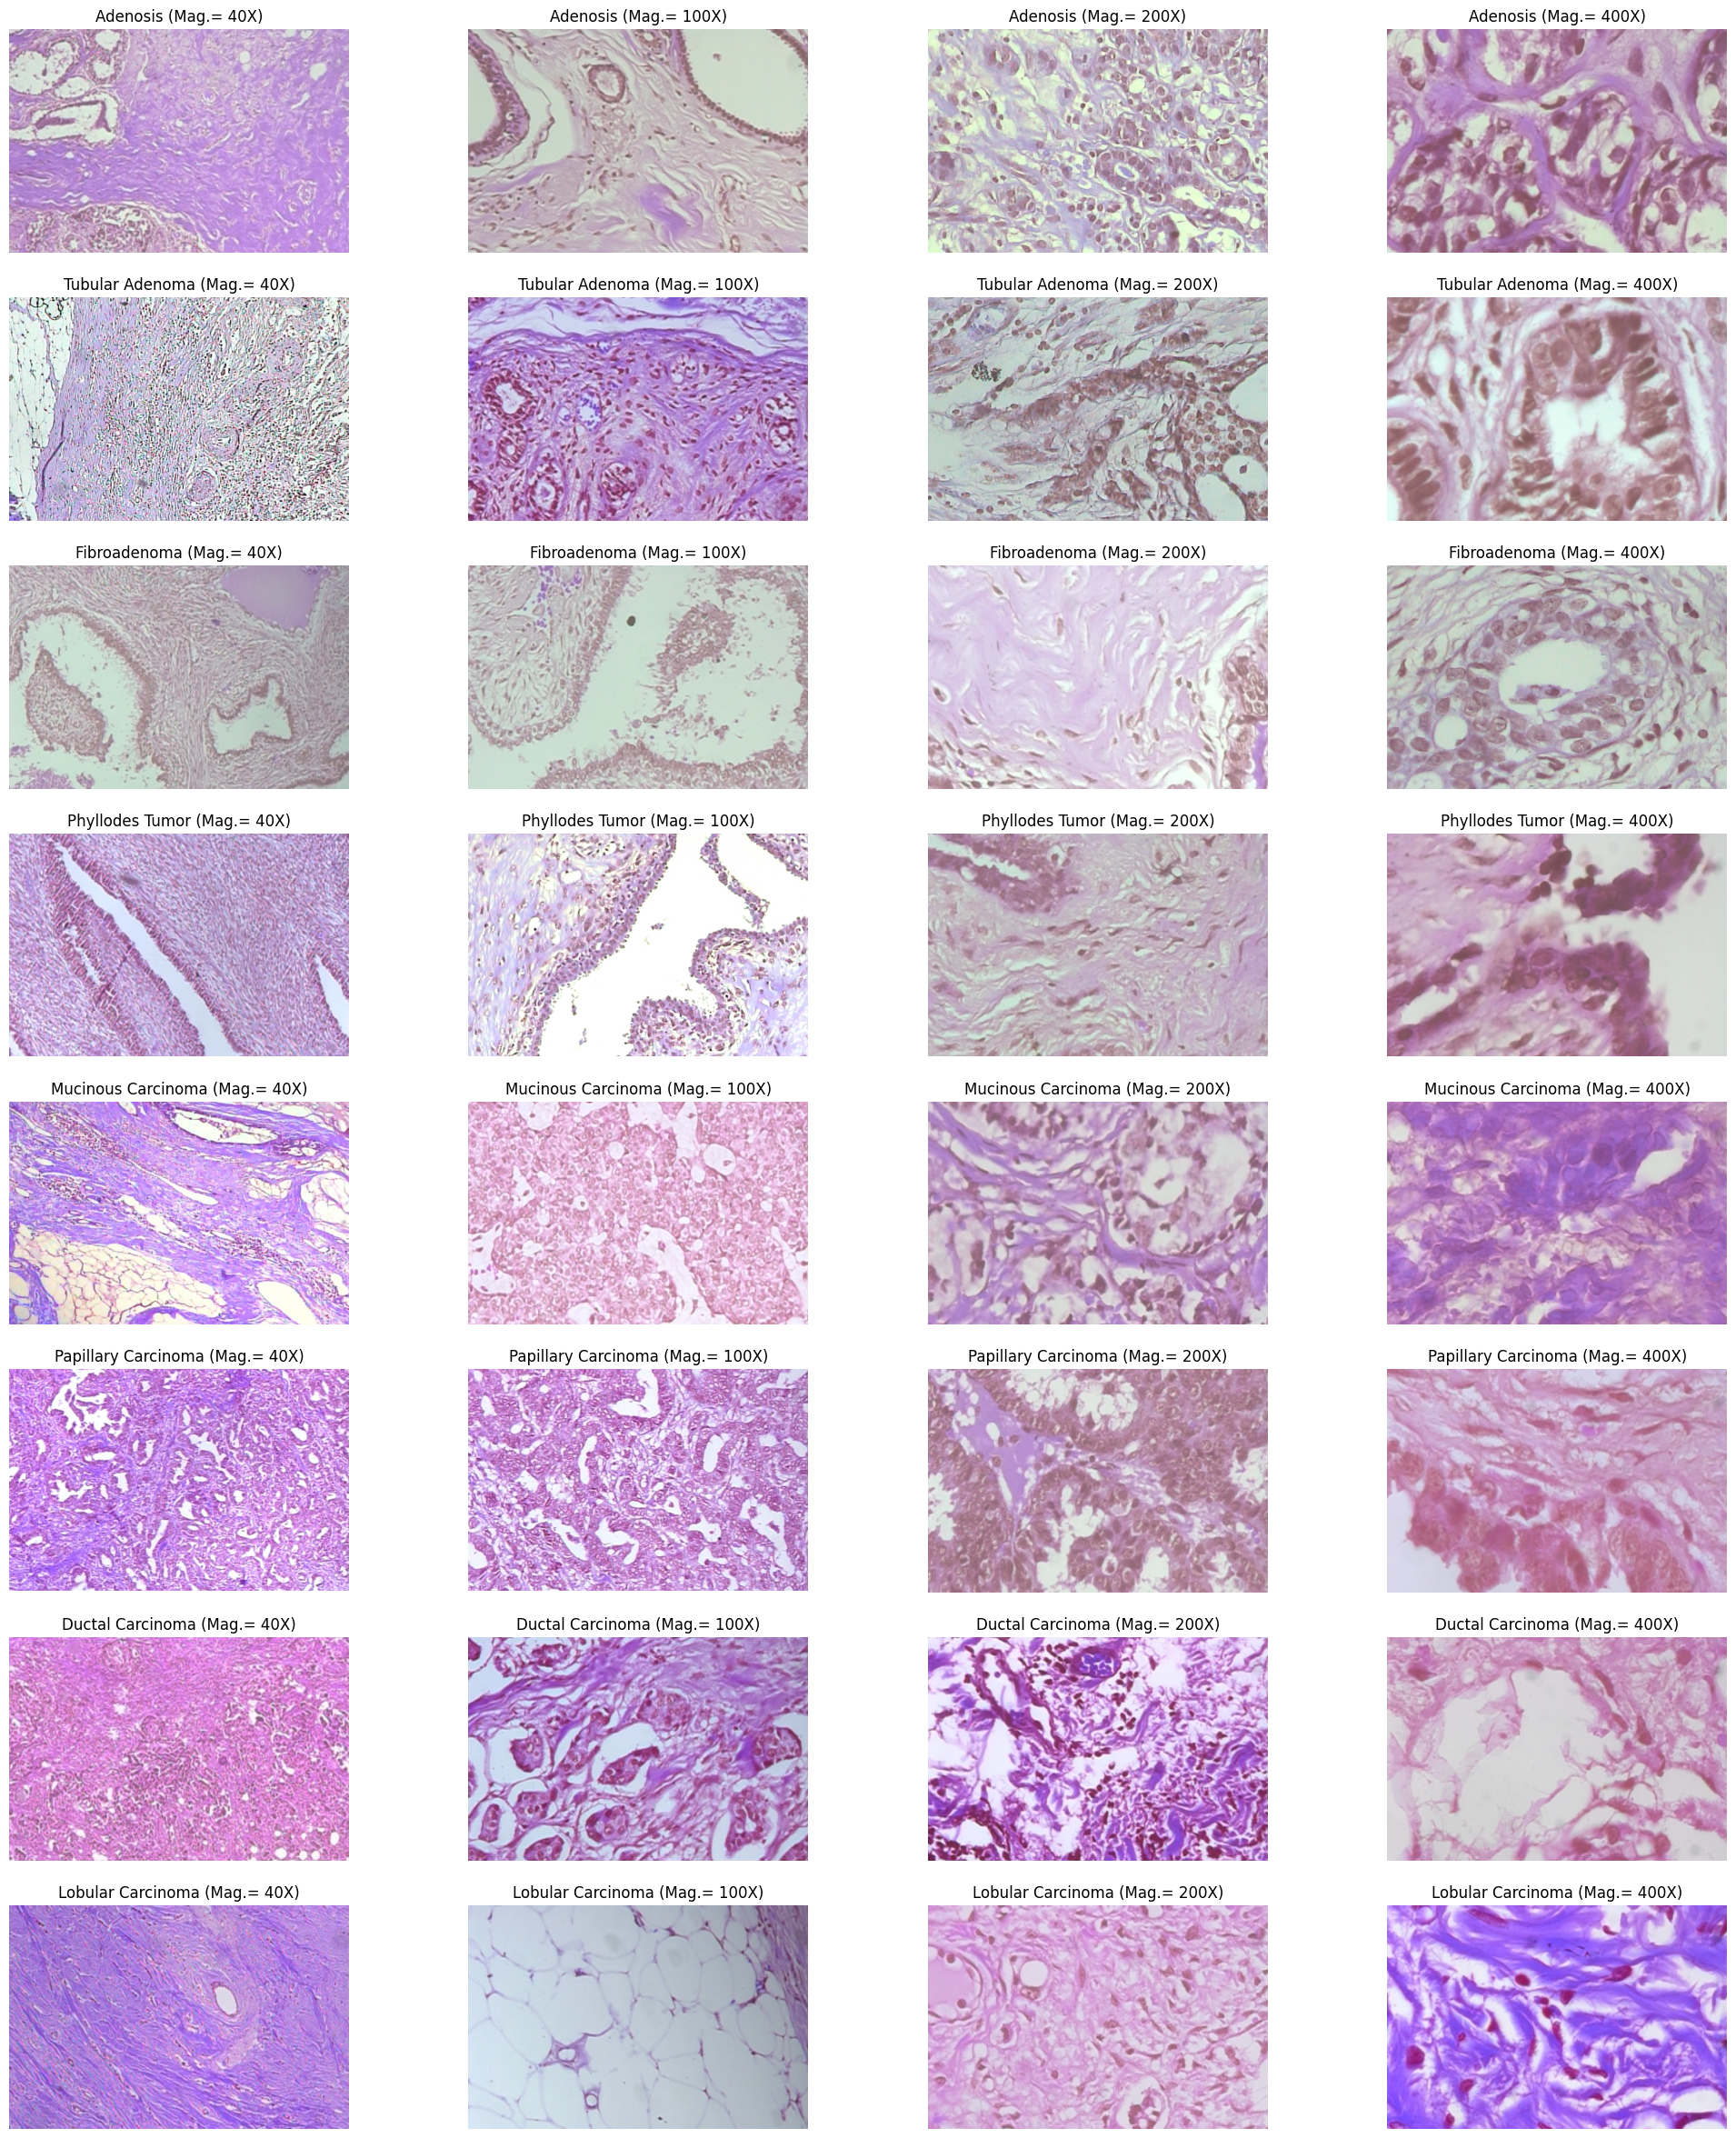

In [19]:
magnifications = ['40X', '100X', '200X', '400X']
cancer_types = list(img_metadata_df['Cancer Type'].unique())
            
plot_images_compare_magnification(img_metadata_df, cancer_types, magnifications)